In [7]:
import psycopg2

API_KEY = '2CDC7D3628A900A6E59E9BC19A8E0B62'

try:
    # Conexão com o banco de dados
    connection = psycopg2.connect(
        host="26.84.71.27",       
        database="DataScienceProj",
        user="postgres",     
        password="SteamDB",    
        port="5432",
        options="-c client_encoding=UTF8"  # Configuração da codificação
    )

    # Criação de um cursor para executar comandos SQL
    cursor = connection.cursor()

    # Exemplo de execução de uma consulta
    cursor.execute("SELECT version();")
    version = cursor.fetchone()
    print("Versão do PostgreSQL:", version)

except Exception as error:
    # Tratamento de erro com codificação segura
    print("Erro ao conectar ao banco de dados:", str(error).encode('utf-8', errors='replace').decode())


Versão do PostgreSQL: ('PostgreSQL 17.2 on x86_64-windows, compiled by msvc-19.41.34123, 64-bit',)


C:\Users\mag\AppData\Local\Temp\ipykernel_19048\3985604818.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql_query(query, connection)
C:\Users\mag\AppData\Local\Temp\ipykernel_19048\3985604818.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='qtdejogos', y='description', palette='viridis')


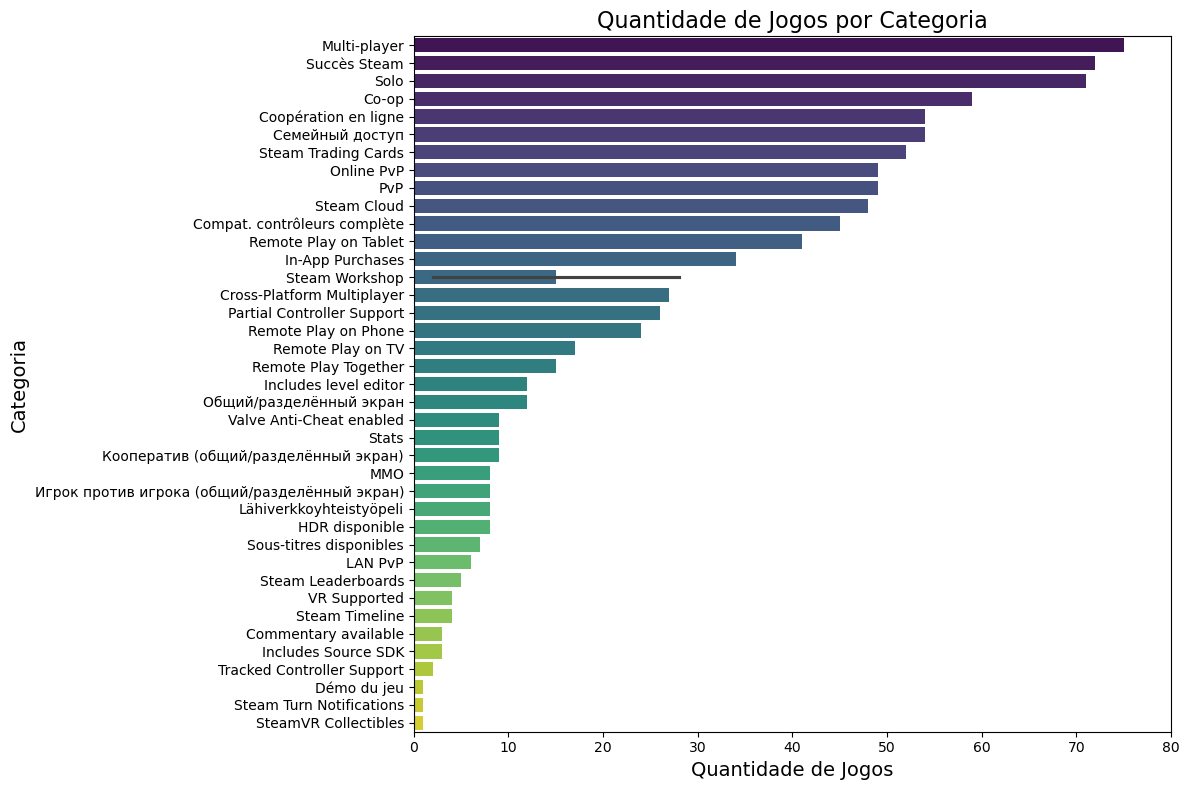

In [5]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Executar a consulta
query = """
SELECT DISTINCT id, 
       (SELECT description 
        FROM steam.games_categories_steam cat 
        WHERE cat.id = a.id LIMIT 1) AS description, 
       qtdejogos 
FROM (
    SELECT DISTINCT id, 
           gcs.description, 
           COUNT(appid) OVER (PARTITION BY gcs.id) AS qtdejogos
    FROM steam.games_categories_steam gcs
) AS a 
ORDER BY qtdejogos DESC
"""
data = pd.read_sql_query(query, connection)

# 3. Fechar a conexão
connection.close()
# 4. Criar o gráfico
plt.figure(figsize=(12, 8))
sns.barplot(data=data, x='qtdejogos', y='description', palette='viridis')
plt.title("Quantidade de Jogos por Categoria", fontsize=16)
plt.xlabel("Quantidade de Jogos", fontsize=14)
plt.ylabel("Categoria", fontsize=14)
plt.xlim(0, data['qtdejogos'].max() + 5)  # Adiciona uma margem para visibilidade

plt.tight_layout()

# 5. Exibir o gráfico
plt.show()

query2 = """ SELECT * FROM """

C:\Users\mag\AppData\Local\Temp\ipykernel_19048\20618521.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql_query(query, connection)
C:\Users\mag\AppData\Local\Temp\ipykernel_19048\20618521.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='PEAK_IN_GAME', y='NAME', palette='viridis')


Conexão encerrada.
                  name  last_week_rank  peak_in_game
0     Counter-Strike 2               1      1461.437
1               Dota 2               2       689.611
2  PUBG: BATTLEGROUNDS               3       768.262
3     Wallpaper Engine               4       125.868
4        Call of Duty®               5       192.963


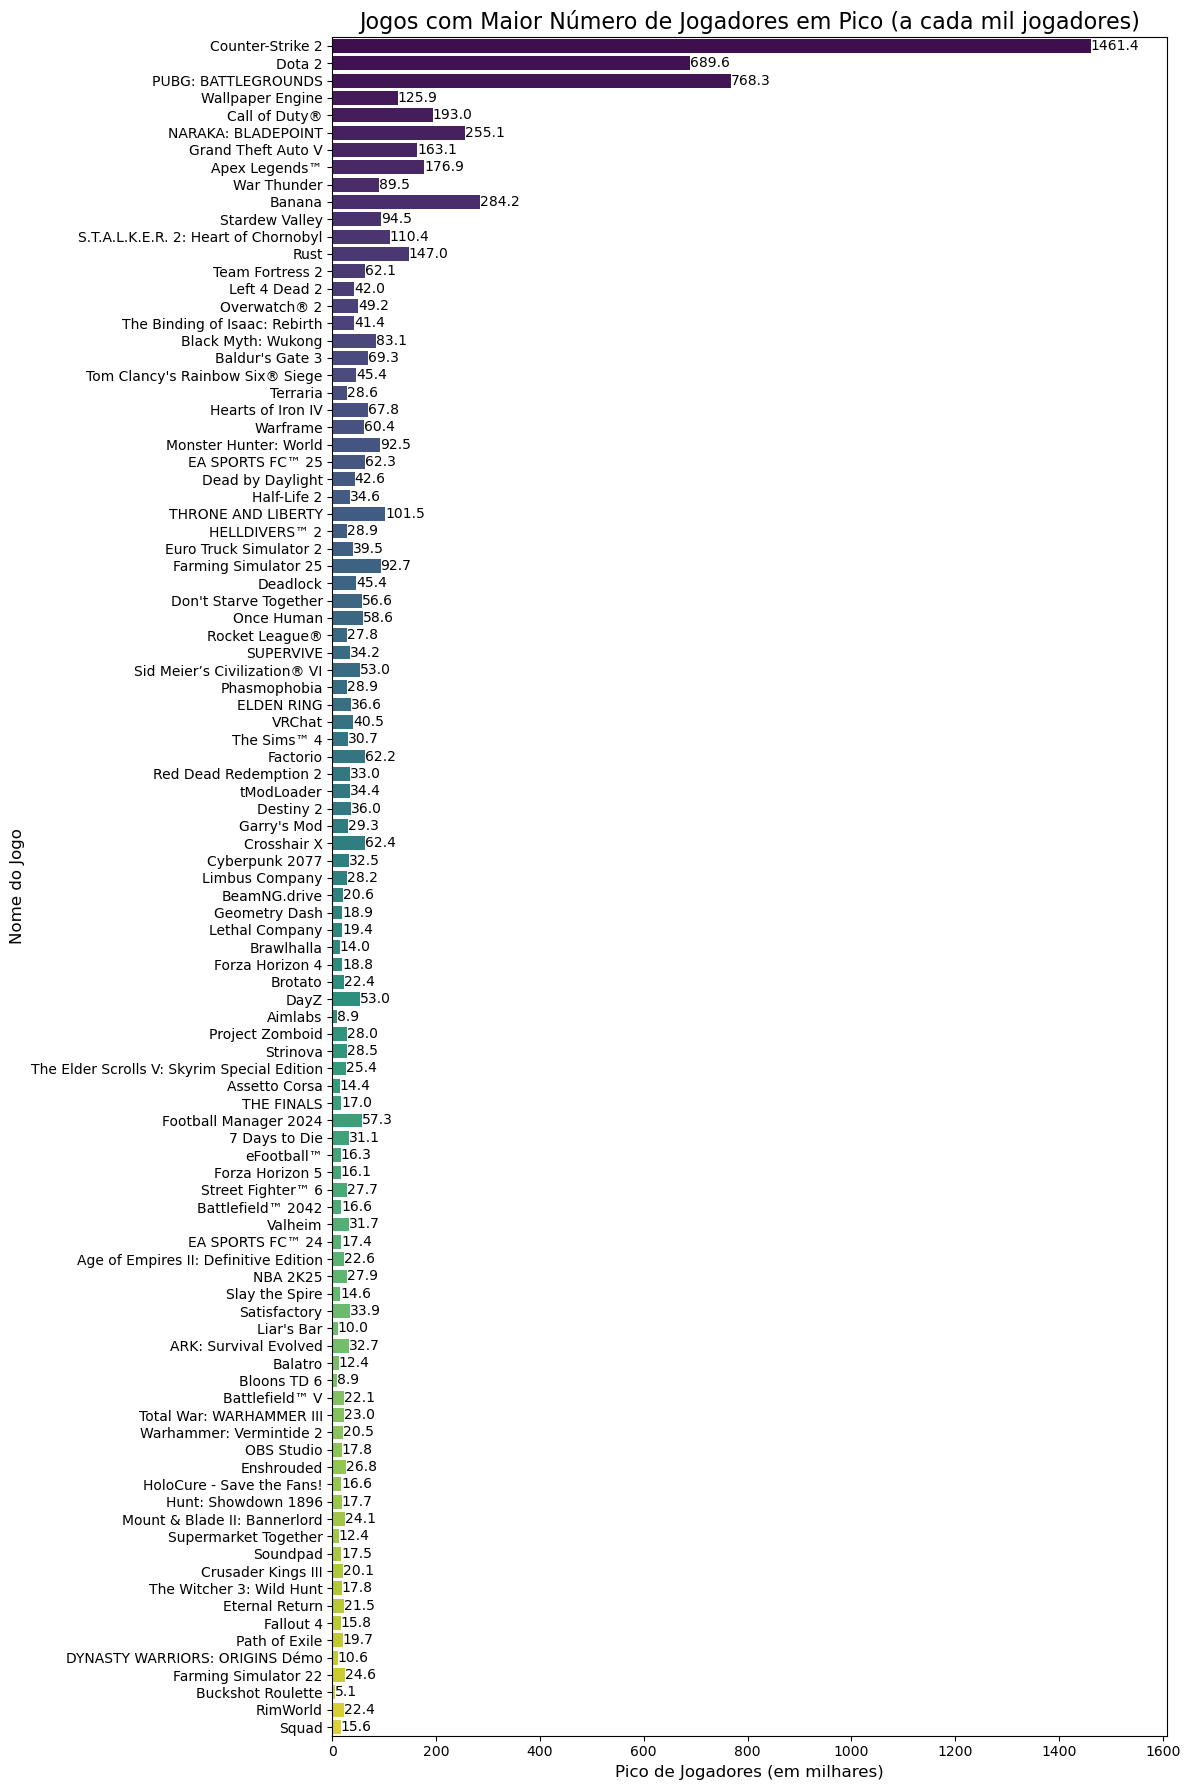

In [8]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


if connection:
    # Definir a consulta SQL
    query = """
    SELECT GI.NAME, 
           G.last_week_rank, 
           (cast(G.peak_in_game as float) / 1000) as peak_in_game
    FROM STEAM.GAMES G
    JOIN STEAM.GAME_INFO GI ON G.APPID = GI.steam_appid
    ORDER BY RANK
    """

    try:
        # Executar a consulta e carregar os dados em um DataFrame
        data = pd.read_sql_query(query, connection)
        connection.close()
        print("Conexão encerrada.")

        # Verificar o DataFrame
        if data.empty:
            print("O DataFrame está vazio. Verifique sua consulta SQL.")
        else:
            print(data.head())  # Exibir as primeiras linhas

            # Certificar-se de que as colunas têm os nomes corretos
            data.columns = [col.strip().upper() for col in data.columns]

            # Plotar o gráfico
            plt.figure(figsize=(12, 18))
            sns.barplot(data=data, x='PEAK_IN_GAME', y='NAME', palette='viridis')

            # Adicionar rótulos com os valores reais
            for index, value in enumerate(data['PEAK_IN_GAME']):
                plt.text(value, index, f"{value:.1f}", va='center', fontsize=10)

            # Configurar título e rótulos
            plt.title("Jogos com Maior Número de Jogadores em Pico (a cada mil jogadores)", fontsize=16)
            plt.xlabel("Pico de Jogadores (em milhares)", fontsize=12)
            plt.ylabel("Nome do Jogo", fontsize=12)

            # Ajustar limites do eixo X automaticamente
            max_peak = data['PEAK_IN_GAME'].max()
            plt.xlim(0, max_peak * 1.1)  # Adicionar 10% de margem

            plt.tight_layout()

            # Exibir o gráfico
            plt.show()
    except Exception as e:
        print(f"Erro ao executar a consulta ou gerar o gráfico: {e}")
